# OnlineL Data Wrangling, Resampling  <a id="isc_isfc_wkflow"></a>
Much of this notebook builds on brainIAK tutorial notebooks as well as my previous work in NEU/ELE 480 as well as builds upon Dr. Meir Meshulam's previous work with this data set, his sugestions for data wrangling, and other publicly available ISC/ISFC related notebooks.

Kumar, M., Anderson, M. J., Antony, J. W., Baldassano, C., Brooks, P. P., Cai, M. B., Chen, P.-H. C., Ellis, C. T., Henselman-Petrusek, G., Huberdeau, D., Hutchinson, J. B., Li, P. Y., Lu, Q., Manning, J. R., Mennen, A. C., Nastase, S. A., Richard, H., Schapiro, A. C., Schuck, N. W., Shvartsman, M., Sundaraman, N., Suo, D., Turek, J. S., Turner, D. M., Vo, V. A., Wallace, G., Wang, Y., Williams, J. A., Zhang, H., Zhu, X., Capota, M., Cohen, J. D., Hasson, U., Li, K., Ramadge, P. J., Turk-Browne, N. B., Willke, T. L., & Norman, K. A. (2021). BrainIAK: The Brain Imaging Analysis Kit. Aperture Neuro, 1(4). https://doi.org/10.52294/31bb5b68-2184-411b-8c00-a1dacb61e1da

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import os 
import glob
import time
from copy import deepcopy
# Import fMRI and general analysis libraries
import nibabel as nib
import numpy as np
import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
import scipy.spatial.distance as sp_distance
import sklearn
from sklearn.svm import NuSVC, LinearSVC
from sklearn import decomposition
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import deepdish as dd

# Import plotting library
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

# Import machine learning libraries
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV, PredefinedSplit
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import sem
from copy import deepcopy



# load some helper functions
from utils import raider_data_dir, load_vdc_mask, load_vdc_epi_data, load_vdc_masked_data 
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run # load some constants

%matplotlib inline 
%autosave 5

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")
from utils import mask_data
from os import listdir, makedirs, walk, remove, getlogin, rename, system, sep, getcwd
from os.path import join, exists, isfile, getmtime, isdir
import numpy as np
import sklearn as sk
import nilearn as nii
from nilearn.plotting import view_img, view_img_on_surf, plot_roi, plot_epi, show
from nilearn import datasets
from nilearn.image import load_img, math_img,index_img
from nilearn.image import resample_img
from nilearn.image import resample_to_img
from time import time
from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc, phaseshift_isc, timeshift_isc, squareform_isfc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm

Autosaving every 5 seconds


##  Setting up directories  <a id="isc_isfc_wkflow"></a>


In [2]:
data_dir=f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep'
mask_dir=f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/masks'
ref = os.path.join(mask_dir,'Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')

### Resampling <a id="isc_isfc_wkflow"></a>


In [44]:
def load_file_resample(sub, task):
    #locate the file
    fname = os.path.join(data_dir, 'sub-%s/func/sub-%s_task-%s_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz' % (sub,sub, task))
    print(fname)
    
    #load file as an image
    img = load_img(fname)
   
    print('dimensions')
    print(nii.image.get_data(img).shape)
    print('affine matrix')
    print(img.affine)

    # make mean image
    mean_img=nii.image.mean_img(img)
    print('mean img dim')
    mean_img.get_fdata().shape
    mean_img.shape
    view_img(mean_img, threshold=None)
    
    resampled_mean_img = resample_to_img(mean_img,ref,interpolation='nearest')
    print(resampled_mean_img.shape)

    t1=time()
    resampled_img = resample_to_img(img,ref,interpolation='nearest')
    t2=time()
    print('timeit:{:.2f}'.format(t2-t1))
    
    fgz=fname.split('/')[-1]
    resampled_2mm=fgz.split('_')[:-1]
    resampled_2mm.append('2mm-iso')
    resampled_2mm.append(fgz.split('_')[-1])
    resampled_2mm='_'.join(resampled_2mm)
    resampled_2mm
    
    save_name= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm'
    resampled_img.to_filename(save_name + '_sub_%s_%s.nii.gz' % (sub, task))

In [65]:
 #locate the file
fname = os.path.join(data_dir, 'sub-01/func/sub-01_task-piemanVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz')
print(fname)
    
img = load_img(fname)
   
print('dimensions')
print(nii.image.get_data(img).shape)
print('affine matrix')
print(img.affine)

    # make mean image
mean_img=nii.image.mean_img(img)
print('mean img dim')
mean_img.get_fdata().shape
mean_img.shape
view_img(mean_img, threshold=None)
    
resampled_mean_img = resample_to_img(mean_img,ref,interpolation='nearest')
print(resampled_mean_img.shape)

t1=time()
resampled_img = resample_to_img(img,ref,interpolation='nearest')
t2=time()
print('timeit:{:.2f}'.format(t2-t1))
    
fgz=fname.split('/')[-1]
resampled_2mm=fgz.split('_')[:-1]
resampled_2mm.append('2mm-iso')
resampled_2mm.append(fgz.split('_')[-1])
resampled_2mm='_'.join(resampled_2mm)
resampled_2mm
    
save_name= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm'
resampled_img.to_filename(save_name + '_sub_01_piemanVid.nii.gz')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-piemanVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 286)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:44.06


In [6]:
sub_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
tasks = ['piemanVid', 'cosVid', 'histVid', 'piemanQA', 'cosQA', 'histQA']

In [19]:
for i in sub_ids:
    load_file_resample(i, 'piemanVid')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-piemanVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 286)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:53.21
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-02/func/sub-02_task-piemanVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 286)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93700004    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:53.35
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/deri

In [21]:
for i in sub_ids:
    load_file_resample(i, 'cosVid')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-cosVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 300)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:54.06
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-02/func/sub-02_task-cosVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 276)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93700004    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:50.77
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivative

In [22]:
for i in sub_ids:
    load_file_resample(i, 'histVid')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-histVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 350)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:62.38
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-02/func/sub-02_task-histVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 351)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93700004    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:60.52
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivati

In [7]:
for i in sub_ids:
    load_file_resample(i, 'piemanQA')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-piemanQA_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 97)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:15.95
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-02/func/sub-02_task-piemanQA_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 136)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93700004    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:23.27
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivat

In [8]:
for i in sub_ids:
    load_file_resample(i, 'cosQA')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-cosQA_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 107)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:18.91
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-02/func/sub-02_task-cosQA_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 150)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93700004    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:25.00
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/

In [10]:
for i in sub_ids:
    load_file_resample(i, 'histQA')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-histQA_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 100)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:18.26
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-02/func/sub-02_task-histQA_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 119)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93700004    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:20.32
/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivative

In [45]:
load_file_resample('01', 'piemanVid')

/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/sub-01/func/sub-01_task-piemanVid_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
dimensions
(94, 113, 91, 286)
affine matrix
[[   1.93799996    0.            0.          -90.        ]
 [   0.            1.93799996    0.         -126.        ]
 [   0.            0.            2.          -72.        ]
 [   0.            0.            0.            1.        ]]
mean img dim
(91, 109, 91)
timeit:45.42


##  Loading data for individual subjects <a id="isc_isfc_wkflow"></a>


In [81]:
ref_img = nib.load(ref)
mean_ref_img=nii.image.mean_img(ref_img)
mean_ref_img.get_fdata().shape

(91, 109, 91)

In [3]:
#subject 3
piemanVid_03 = '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm_sub_03_piemanVid.nii.gz'
img_piemanVid_03 = nib.load(piemanVid_03)
bold_piemanVid_03 = img_piemanVid_03.get_fdata()
mean_bold_piemanVid_03 = np.mean(bold_piemanVid_03, axis = -1)
mean_img_piemanVid_03=nii.image.mean_img(img_piemanVid_03)

print("the shape of sub3 pieman video is ", bold_piemanVid_03.shape, "and the mean, shape is", mean_bold_piemanVid_03.shape)

the shape of sub3 pieman video is  (91, 109, 91, 285) and the mean, shape is (91, 109, 91)


In [3]:
#subject 1
piemanVid_01 = '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm_sub_01_piemanVid.nii.gz'
img_piemanVid_01 = nib.load(piemanVid_01)
bold_piemanVid_01 = img_piemanVid_01.get_fdata()
mean_bold_piemanVid_01 = np.mean(bold_piemanVid_01, axis = -1)
mean_img_piemanVid_01=nii.image.mean_img(img_piemanVid_01)
#mean_bold_piemanVid_01 = mean_img_piemanVid_01.get_fdata()
print("mean bold shape is ", mean_bold_piemanVid_01.shape, "and the bold data shape is ",bold_piemanVid_01.shape)

mean bold shape is  (91, 109, 91) and the bold data shape is  (91, 109, 91, 286)


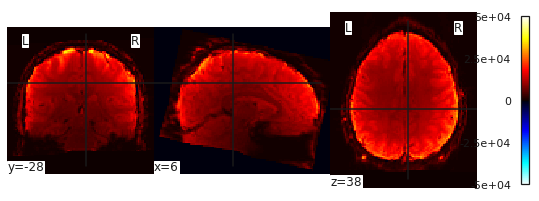

In [4]:
plotting.plot_stat_map(mean_img_piemanVid_01, threshold=None)

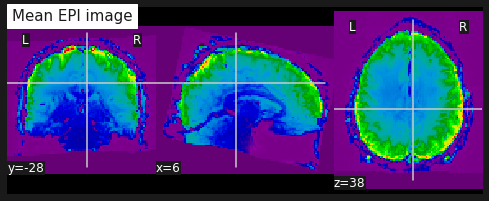

In [106]:
#messy
plot_epi(mean_img_piemanVid_01, title='Mean EPI image')

In [7]:
bold_piemanVid_01.shape

(91, 109, 91, 286)

In [8]:
bold_piemanVid_01[30,30,30].shape

(286,)

In [46]:
bold_piemanVid_03[10,10,10]

array([484.40456218, 464.36878914, 513.90167248, 572.8958931 ,
       508.33617997, 522.24991125, 495.5355472 , 503.32723671,
       520.02371424, 397.02632976, 515.57132024, 503.88378596,
       395.91323125, 550.63392305, 525.0326575 , 442.66336834,
       527.25885451, 461.02949363, 518.91061574, 504.44033521,
       545.62497979, 490.52660394, 516.68441874, 464.36878914,
       474.38667566, 486.63075918, 497.20519495, 409.27041328,
       537.83329028, 433.75858033, 375.87745821, 434.31512958,
       403.14837152, 447.6723116 , 472.7170279 , 461.02949363,
       542.28568429, 428.19308782, 515.01477098, 381.44295073,
       419.2882998 , 580.68758261, 504.99688447, 470.4908309 ,
       425.96689081, 500.54449046, 388.67809099, 402.59182227,
       456.02055037, 468.26463389, 468.82118315, 518.35406649,
       525.58920676, 489.41350543, 451.01160711, 492.75280094,
       421.5144968 , 428.19308782, 387.56499249, 467.70808464,
       457.13364887, 443.2199176 , 471.04738015, 358.06

In [43]:
img_piemanVid_03.header
print(img_piemanVid_03.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91 285   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-2.  0.  0. 90.]
srow_

In [44]:
img_piemanVid_01.header
print(img_piemanVid_01.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91 286   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-2.  0.  0. 90.]
srow_

##  Loading Parcellation Atlas  <a id="isc_isfc_wkflow"></a>


In [8]:
# load some parcellation and view
path_atlas_folder=f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/parcellations/'
# create atlas obj
n_roi=200
n_yeo_nets=7
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_roi, yeo_networks=n_yeo_nets, resolution_mm=2, data_dir=path_atlas_folder, base_url=None, resume=True, verbose=1)
labels = atlas.labels
print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas.maps)  # 4D data

Atlas ROIs are located in nifti image (4D) at: /mnt/cup/labs/hasson/daniellacohen/seniorResearch/parcellations/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


In [7]:
# Print the labels
# Create a Pandas dataframe of the atlas data for easy inspection.
atlas_pd = pd.DataFrame(atlas)
print(atlas_pd['labels'])

0                   b'7Networks_LH_Vis_1'
1                   b'7Networks_LH_Vis_2'
2                   b'7Networks_LH_Vis_3'
3                   b'7Networks_LH_Vis_4'
4                   b'7Networks_LH_Vis_5'
                      ...                
195    b'7Networks_RH_Default_PFCdPFCm_6'
196    b'7Networks_RH_Default_PFCdPFCm_7'
197     b'7Networks_RH_Default_pCunPCC_1'
198     b'7Networks_RH_Default_pCunPCC_2'
199     b'7Networks_RH_Default_pCunPCC_3'
Name: labels, Length: 200, dtype: object


In [60]:
atlas_pd['labels'][100:114]

100     b'7Networks_RH_Vis_1'
101     b'7Networks_RH_Vis_2'
102     b'7Networks_RH_Vis_3'
103     b'7Networks_RH_Vis_4'
104     b'7Networks_RH_Vis_5'
105     b'7Networks_RH_Vis_6'
106     b'7Networks_RH_Vis_7'
107     b'7Networks_RH_Vis_8'
108     b'7Networks_RH_Vis_9'
109    b'7Networks_RH_Vis_10'
110    b'7Networks_RH_Vis_11'
111    b'7Networks_RH_Vis_12'
112    b'7Networks_RH_Vis_13'
113    b'7Networks_RH_Vis_14'
Name: labels, dtype: object

In [50]:
labels

array([b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2',
       b'7Networks_LH_Vis_3', b'7Networks_LH_Vis_4',
       b'7Networks_LH_Vis_5', b'7Networks_LH_Vis_6',
       b'7Networks_LH_Vis_7', b'7Networks_LH_Vis_8',
       b'7Networks_LH_Vis_9', b'7Networks_LH_Vis_10',
       b'7Networks_LH_Vis_11', b'7Networks_LH_Vis_12',
       b'7Networks_LH_Vis_13', b'7Networks_LH_Vis_14',
       b'7Networks_LH_SomMot_1', b'7Networks_LH_SomMot_2',
       b'7Networks_LH_SomMot_3', b'7Networks_LH_SomMot_4',
       b'7Networks_LH_SomMot_5', b'7Networks_LH_SomMot_6',
       b'7Networks_LH_SomMot_7', b'7Networks_LH_SomMot_8',
       b'7Networks_LH_SomMot_9', b'7Networks_LH_SomMot_10',
       b'7Networks_LH_SomMot_11', b'7Networks_LH_SomMot_12',
       b'7Networks_LH_SomMot_13', b'7Networks_LH_SomMot_14',
       b'7Networks_LH_SomMot_15', b'7Networks_LH_SomMot_16',
       b'7Networks_LH_DorsAttn_Post_1', b'7Networks_LH_DorsAttn_Post_2',
       b'7Networks_LH_DorsAttn_Post_3', b'7Networks_LH_DorsAttn_Post_4',

In [11]:
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(img_piemanVid_03)
# note this is what it was before
#time_series = masker.fit_transform(fmri_filenames, confounds=data.confounds)

[NiftiLabelsMasker.fit_transform] loading data from /mnt/cup/labs/hasson/daniellacohen/seniorResearch/parcellations/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[Memory]5.9s, 0.1min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [37]:
print("the shape of the time_series is ", time_series.shape)
#why is this one TR off?

the shape of the time_series is  (285, 200)


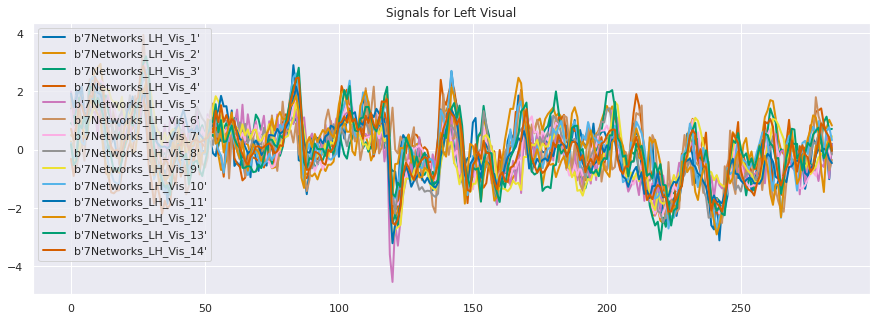

In [53]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for label_idx in range(14):
    ax.plot(time_series[:, label_idx],
            linewidth=2,
            label=atlas.labels[label_idx]) 
ax.legend(loc=2)
ax.set_title("Signals for Left Visual")
plt.show()
# y units are the z score because centered around 0.

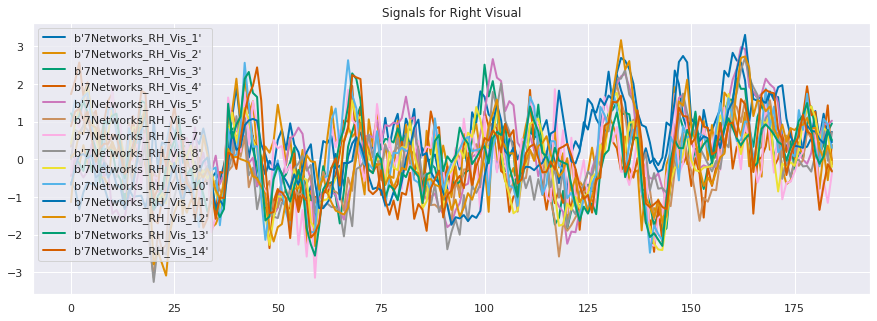

In [64]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for label_idx in range(14):
    ax.plot(time_series[100:, 100 + label_idx],
            linewidth=2,
            label=atlas.labels[100 + label_idx]) 
ax.legend(loc=2)
ax.set_title("Signals for Right Visual")
plt.show()

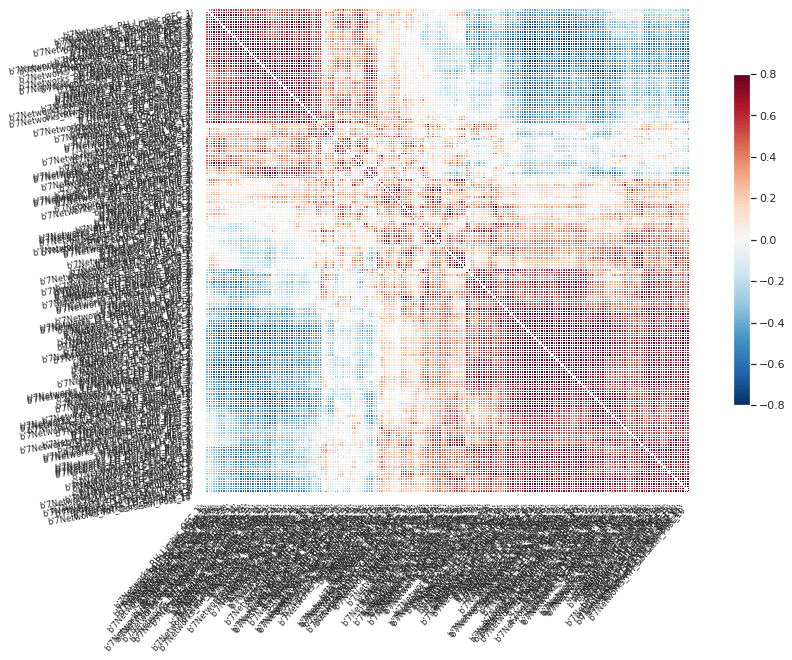

In [29]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 10), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

In [ ]:
^make sense of this, one hemisphere at a time 

In [25]:
correlation_matrix.shape

(200, 200)

In [62]:
parcel_bold = []

# loop through the ints
#label is 0:199
for label in np.arange(200):
    parcel_data = mean_bold_piemanVid_03[atlas == label]
    parcel_mean = np.mean(parcel_data, axis = 0)
    parcel_bold.append(parcel_mean)

In [66]:
parcel_bold[4][10:100:10]

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [ ]:
# Create a masker object that we can use to select ROIs
masker_ho = NiftiLabelsMasker(labels_img=atlas_filename)
print(masker_ho.get_params())

# Apply our atlas to the Nifti object so we can pull out data from single parcels/ROIs
bold_ho = masker_ho.fit_transform(nii)
print('shape: parcellated bold time courses: ', np.shape(bold_ho))

In [7]:
n_regions = len(atlas.labels)-1 # rm background region 
print('number of parcels:\t {}'.format(n_regions))

number of parcels:	 199


In [15]:
atlas.labels[100]

b'7Networks_RH_Vis_1'

##  Early Visual Mask  <a id="isc_isfc_wkflow"></a>
Masks from NeuroSynth.org

(91, 109, 91)



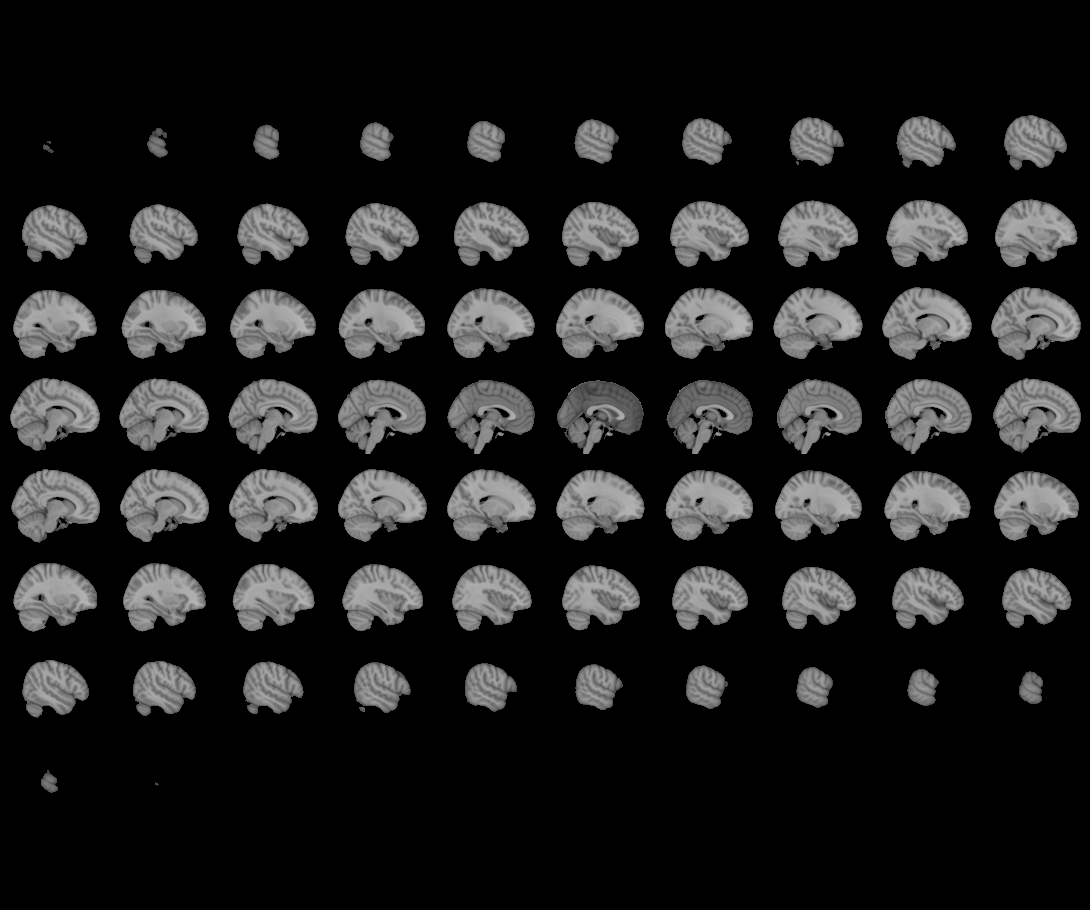
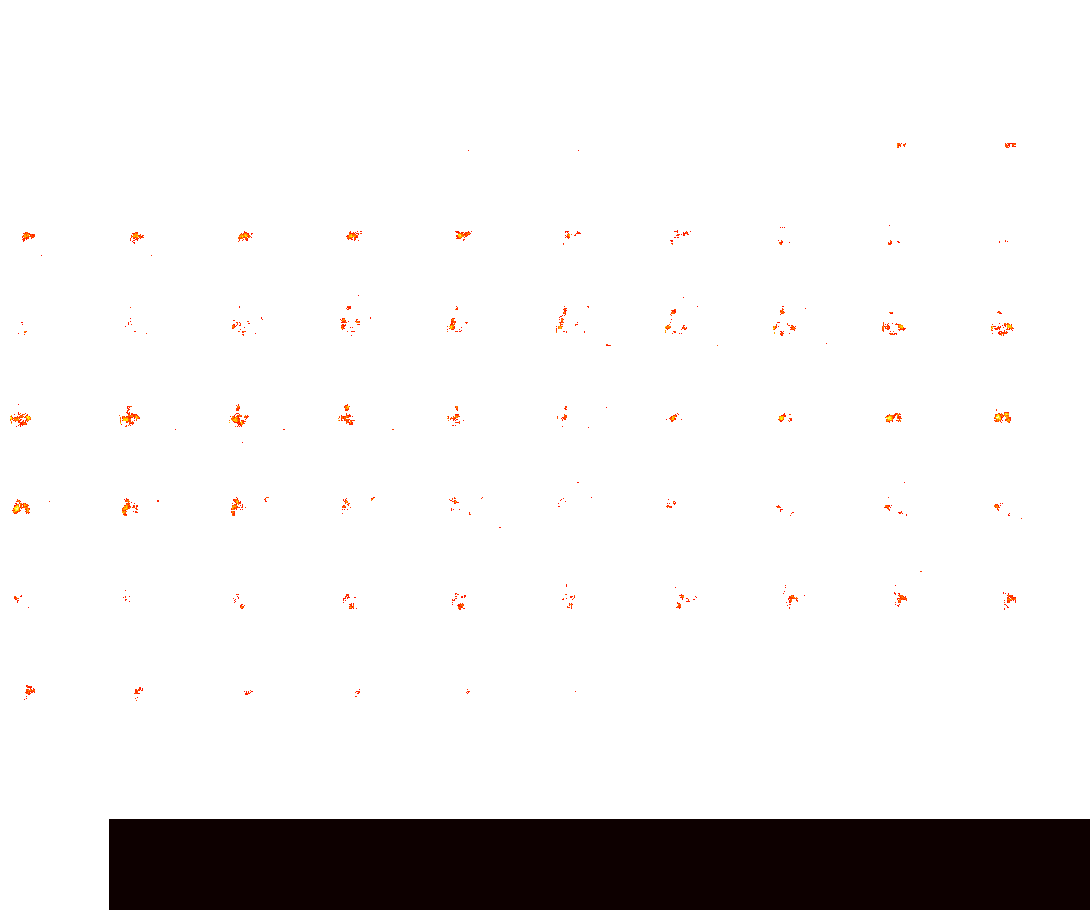

In [12]:
ev_mask_file = f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/masks/neurosynth/early visual_association-test_z_FDR_0.01.nii.gz'
ev_mask = nib.load(ev_mask_file)
print(ev_mask.shape)
view_img(ev_mask)

In [13]:
#get mask as a boolean
ev_bool_mask = io.load_boolean_mask(ev_mask_file)

# Get the list of nonzero voxel coordinates
ev_coords = np.where(ev_bool_mask)
print(ev_coords)
# Load the brain nii image
#ev_bool_nii = nib.load(ev_mask)

(array([15, 16, 16, ..., 72, 75, 76]), array([30, 30, 31, ..., 33, 33, 32]), array([36, 35, 34, ..., 38, 31, 31]))


##  Visual Cortex Mask  <a id="isc_isfc_wkflow"></a>


(91, 109, 91)


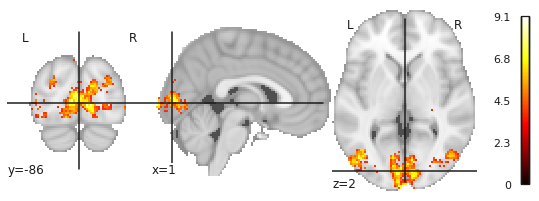

In [7]:
vc_mask_file = f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/masks/neurosynth/visual cortex_association-test_z_FDR_0.01.nii.gz'
vc_mask = nib.load(vc_mask_file)
print(vc_mask.shape)
plotting.plot_stat_map(vc_mask)

In [19]:
vc_bool_mask = io.load_boolean_mask(vc_mask_file)

# Get the list of nonzero voxel coordinates
vc_coords = np.where(vc_bool_mask)
print(vc_coords)

# Load the brain nii image
#brain_nii = nib.load(vc_mask)

(array([14, 15, 16, ..., 72, 72, 72]), array([54, 54, 54, ..., 28, 28, 28]), array([60, 58, 60, ..., 39, 40, 41]))


In [20]:
vc_mask.shape

(91, 109, 91)

In [24]:
print(brain_mask.shape, brain_nii.shape)

(61, 73, 61) (61, 73, 61)


In [139]:
vc_piemanVid_03 = mean_bold_piemanVid_03[vc_bool_mask]
vc_piemanVid_03.shape

(3839,)

In [25]:
vc_bool_mask.shape

(91, 109, 91)

In [26]:
bold_piemanVid_03.shape

(91, 109, 91, 285)

In [29]:
np.mean(bold_piemanVid_03[vc_bool_mask], axis = 0).shape # entire time course for each voxel, #x voxels, by y 

(285,)

In [28]:
mean_bold_piemanVid_03.shape

(91, 109, 91)

In [21]:
# this is the activitiy in the visual cortex
vc_piemanVid_03 =bold_piemanVid_03[vc_bool_mask]

In [134]:
vc_piemanVid_03[:,0].shape

(3839,)

Text(0.5, 1.0, 'activity in visual cortex over time ')

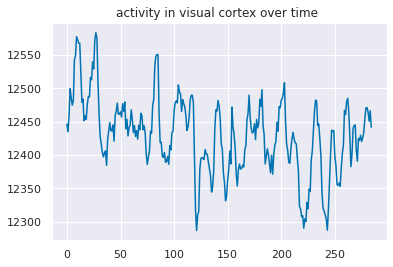

In [31]:
plt.plot(np.mean(bold_piemanVid_03[vc_bool_mask], axis = 0));
plt.title('activity in visual cortex over time ')

Text(0.5, 1.0, 'activity in early visual cortex over time ')

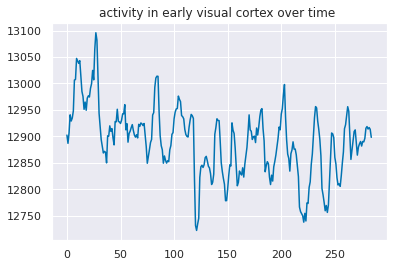

In [33]:
plt.plot(np.mean(bold_piemanVid_03[ev_bool_mask], axis = 0))
plt.title('activity in early visual cortex over time ')

### Previous Brain Mask Work  <a id="isc_isfc_wkflow"></a>


In [12]:
data.shape

(94, 113, 91, 300)

In [60]:
type(data)

numpy.ndarray

In [24]:
data[:,50,:,10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

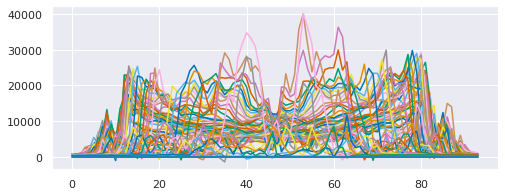

In [30]:
f,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(data[:,50,:,10]);

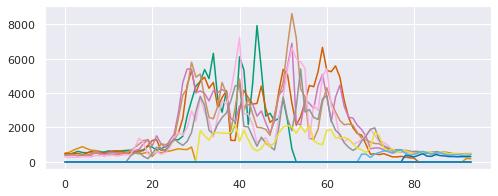

In [33]:
f,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(data[:,4,:,40]);

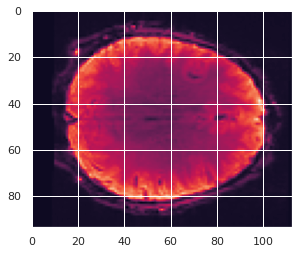

In [13]:
plt.imshow(data[:,:,50,100])

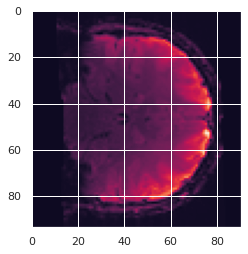

In [14]:
 plt.imshow(data[:,50,:,10])

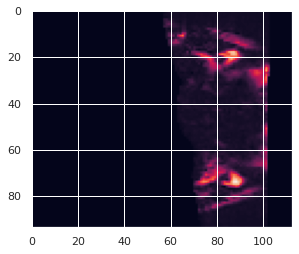

In [15]:
 plt.imshow(data[:,:,9,10])

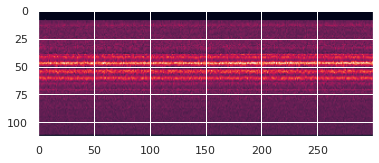

In [16]:
 plt.imshow(data[4,:,50,:])

**Visualizing the brain mask:**<a id="ex1"></a> 


Text(0.5, 1.0, 'title')

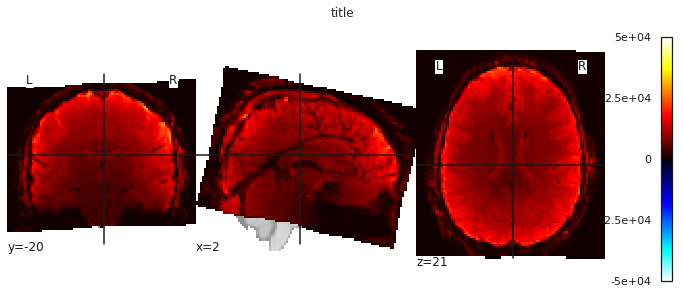

In [51]:
thresh = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    mean_img_piemanVid_01, 
    threshold=thresh, 
    axes=ax
)
ax.set_title('title') 